In [8]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Lambda
from keras.layers import Embedding
from keras.layers import Convolution1D,MaxPooling1D, Flatten
from keras.datasets import imdb
from keras import backend as K
from sklearn.model_selection import train_test_split
import pandas as pd
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import Normalizer
from keras.models import Sequential
from keras.layers import Convolution1D, Dense, Dropout, Flatten, MaxPooling1D
from keras.utils import np_utils
import numpy as np
import h5py
from keras import callbacks
from keras.layers import LSTM, GRU, SimpleRNN
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [9]:
from google.colab import files
files.upload()

!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json


In [10]:
!kaggle datasets download -d kiranmahesh/nslkdd

nslkdd.zip: Skipping, found more recently modified local copy (use --force to force download)


In [11]:
from zipfile import ZipFile
file_name='/content/nslkdd.zip'
with ZipFile(file_name,'r') as zip:
  zip.extractall()

In [12]:
traindata = pd.read_csv('/content/kdd_train.csv')
testdata = pd.read_csv('/content/kdd_test.csv')

In [13]:
data = pd.concat([traindata,testdata])
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [14]:
categ = ['protocol_type','service','flag']
# Encode Categorical Columns
le = LabelEncoder()
data[categ] = data[categ].apply(le.fit_transform)

In [15]:
labels=[]
for i in data['labels']:
    if i=='normal':
        labels.append(0)
    else:
        labels.append(1)
data['labels']=labels

In [16]:
X = data.iloc[:,1:41]
Y = data['labels']


In [17]:
scaler = Normalizer().fit(X)
X = scaler.transform(X)

In [18]:
X_train, X_test,Y_train,Y_test = train_test_split(X,Y, test_size=0.2)

In [19]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))


In [20]:
X_train.shape

(118813, 40, 1)

In [21]:
cnn = Sequential()
cnn.add(Convolution1D(128 ,3,activation="relu",input_shape=(40, 1)))
cnn.add(MaxPooling1D(2))
cnn.add(LSTM(70,activation="relu"))
cnn.add(Flatten())
cnn.add(Dropout(0.1))
cnn.add(Dense(1, activation="sigmoid"))


In [22]:
# define optimizer and objective, compile cnn

cnn.compile(loss="binary_crossentropy", optimizer="adam",metrics=['accuracy'])

In [23]:
# train
checkpointer = callbacks.ModelCheckpoint(filepath="results/cnn1results/checkpoint-{epoch:02d}.hdf5", verbose=1, save_best_only=True, monitor='val_acc',mode='max')


In [24]:
history=cnn.fit(X_train, Y_train, epochs=75,verbose=1,batch_size=500,validation_data=(X_test, Y_test),callbacks=[checkpointer])


Epoch 1/75
238/238 [==============================] - 30s 56ms/step - loss: 0.3176 - accuracy: 0.8781 - val_loss: 0.1952 - val_accuracy: 0.9146
Epoch 2/75
238/238 [==============================] - 10s 43ms/step - loss: 0.1822 - accuracy: 0.9247 - val_loss: 0.1528 - val_accuracy: 0.9452
Epoch 3/75
238/238 [==============================] - 10s 43ms/step - loss: 0.1502 - accuracy: 0.9462 - val_loss: 0.1356 - val_accuracy: 0.9509
Epoch 4/75
238/238 [==============================] - 10s 42ms/step - loss: 0.1557 - accuracy: 0.9396 - val_loss: 0.1877 - val_accuracy: 0.9138
Epoch 5/75
238/238 [==============================] - 10s 43ms/step - loss: 0.1353 - accuracy: 0.9505 - val_loss: 0.1224 - val_accuracy: 0.9537
Epoch 6/75
238/238 [==============================] - 11s 44ms/step - loss: 0.1212 - accuracy: 0.9549 - val_loss: 0.1091 - val_accuracy: 0.9570
Epoch 7/75
238/238 [==============================] - 10s 42ms/step - loss: 0.1121 - accuracy: 0.9574 - val_loss: 0.1022 - val_accuracy:

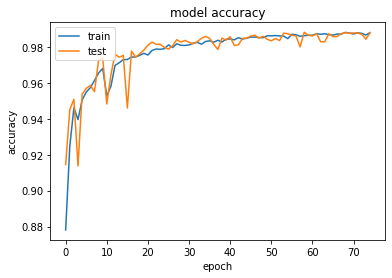

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

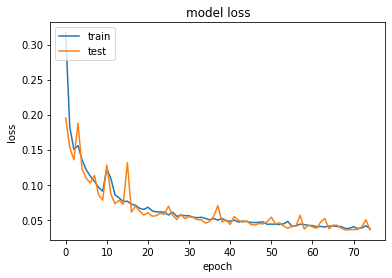

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
cnn.save("results/cnn1results/cnn_model.hdf5")